In [41]:
import datetime
import helper
import os
import pandas as pd


# All files from teslamotorsinc-my.sharepoint.com are placed under energy_data
# in this project. These files are provided seprately.
DATA_FILE_LOCATION = os.path.join(os.getcwd(), "energy_data")

# Plot data and generate metrics for:
site = 28713610
asset = 2069268734
component = -7388072

In [42]:
# Gather data filenames for import from the file system
signal_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "signals_data" in f]
alert_filenames = [f for f in os.listdir(DATA_FILE_LOCATION) if "alerts_data" in f]

if len(signal_filenames)==0 or len(alert_filenames)==0:
    raise Exception("ERROR: CSV data files were not found. These should be added under /energy_data")

# Import signals and alerts from all the files into dataframes.
# There is not much data so this should be okay
# Otherwise I would tackle this day by day, as pandas is all in-memory
signal_df = helper.import_csv_files(DATA_FILE_LOCATION, signal_filenames)
alert_df = helper.import_csv_files(DATA_FILE_LOCATION, alert_filenames)

# Also clean the signal data for unrealistic temperatures as explained in input_validation.ipynb
# signal_df = helper.clean_temperature_data(signal_df)

# Datetime convert the raw timestamp
signal_df["datetime_timestamp"] = pd.to_datetime(
    signal_df['timestamp'], unit='ms'
)

# Add datetime to the alert data as well
alert_df["datetime_timestamp"] = pd.to_datetime(
    alert_df['timestamp'], unit='ms'
)

array([<AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>,
       <AxesSubplot:xlabel='datetime_timestamp'>], dtype=object)

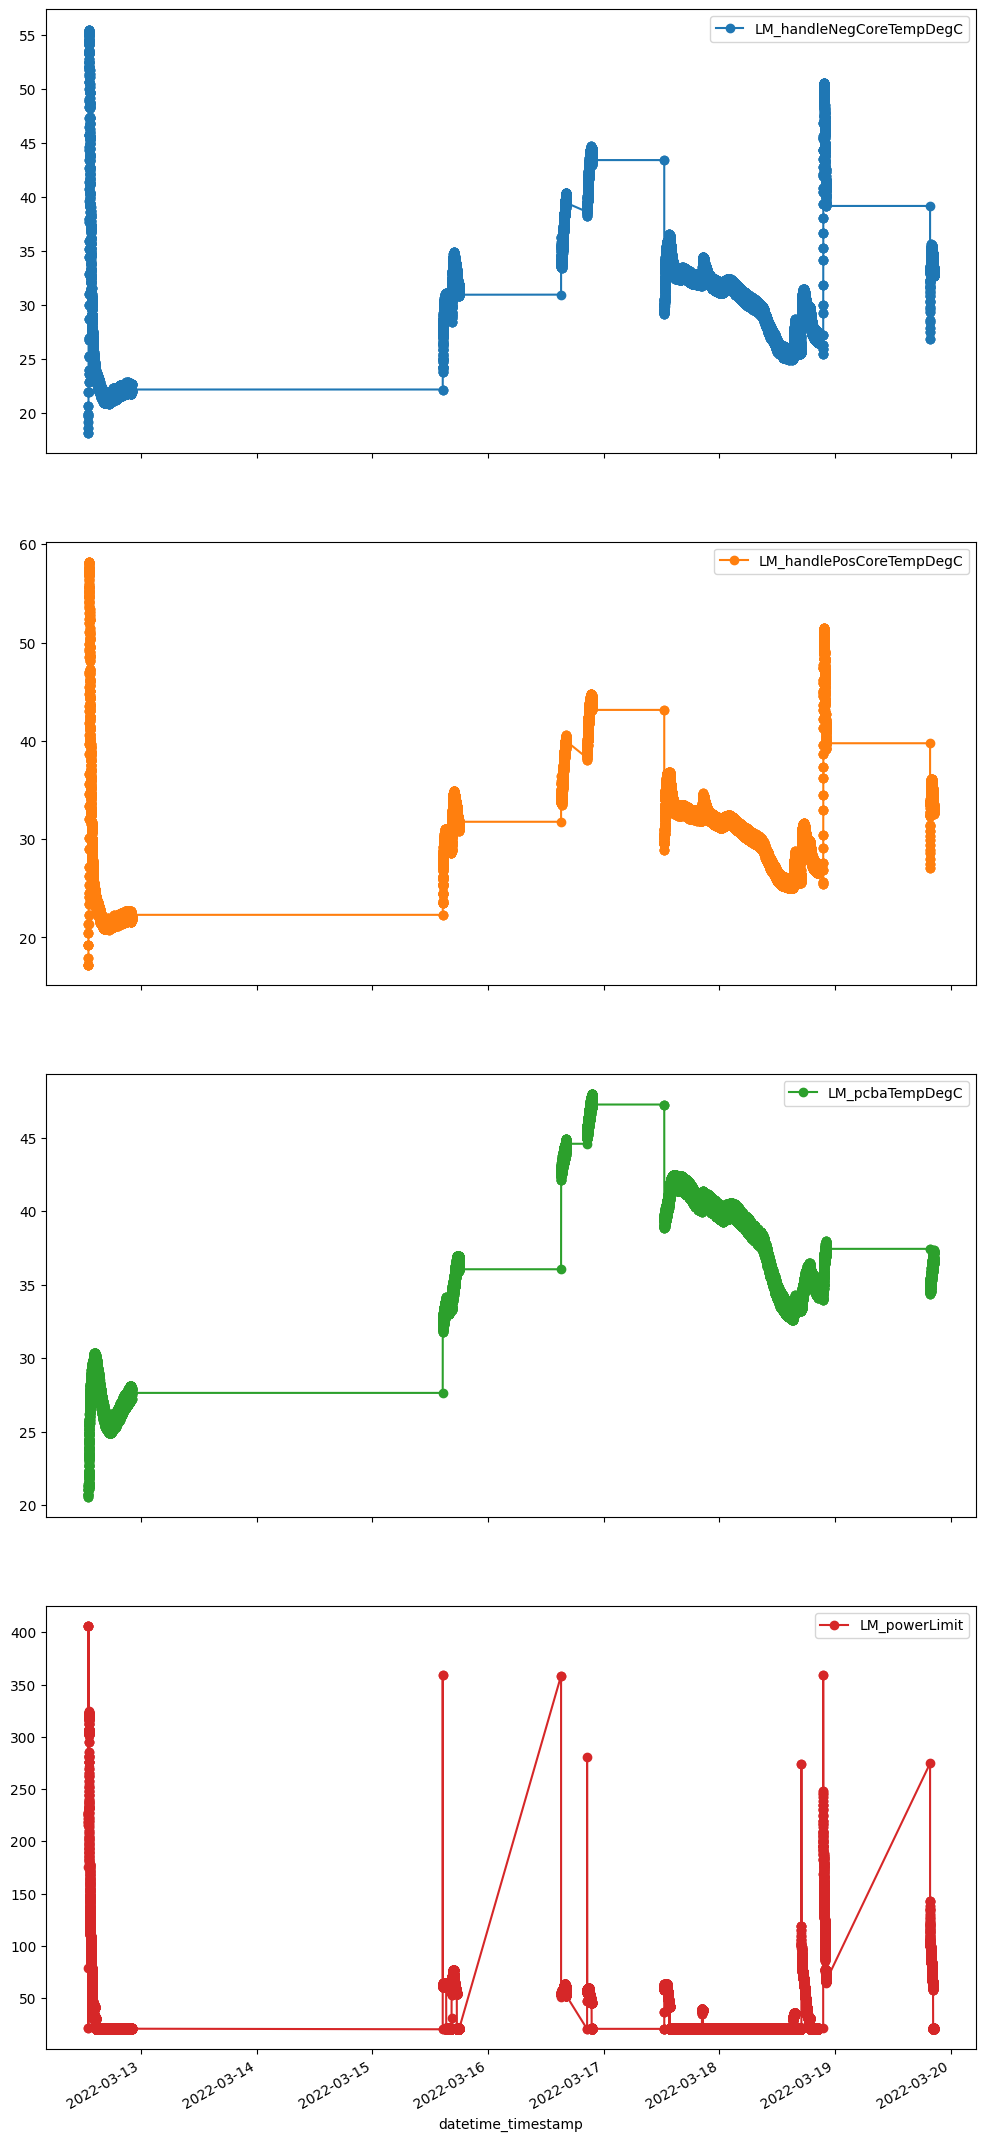

In [43]:
example_component_df = signal_df[
      (signal_df['SITE']==site) 
    & (signal_df['ASSET']==asset)
    & (signal_df['COMPONENT']==component)
]

temp_df = pd.pivot_table(example_component_df,
                          index='datetime_timestamp', 
                          columns=['signal_name'],
                          values='VALUE')

temp_df.ffill().plot(subplots=True, marker="o", figsize=(12,30))

In [44]:
# Now selectively interpolate forward for other signals
for signal in ['LM_pcbaTempDegC', 'LM_powerLimit']:
    temp_df[signal] = temp_df[signal].interpolate()

# And drop rows that don't line up with 'LM_handleNegCoreTempDegC', 'LM_handlePosCoreTempDegC'
# It's also a good idea to drop_duplicates in case there are any double timestamped data
temp_df = temp_df.dropna().drop_duplicates()

 # Perform all the simple aggregations with agg()
daily_aggregations = temp_df.groupby(temp_df.index.date).agg(
    LM_handleNegCoreTempDegC_min=('LM_handleNegCoreTempDegC', 'min'),
    LM_handleNegCoreTempDegC_avg=('LM_handleNegCoreTempDegC', 'mean'),
    LM_handleNegCoreTempDegC_max=('LM_handleNegCoreTempDegC', 'max'),

    LM_handlePosCoreTempDegC_min=('LM_handlePosCoreTempDegC', 'min'),
    LM_handlePosCoreTempDegC_avg=('LM_handlePosCoreTempDegC', 'mean'),
    LM_handlePosCoreTempDegC_max=('LM_handlePosCoreTempDegC', 'max'),

    LM_pcbaTempDegC_min=('LM_pcbaTempDegC', 'min'),
    LM_pcbaTempDegC_avg=('LM_pcbaTempDegC', 'mean'),
    LM_pcbaTempDegC_max=('LM_pcbaTempDegC', 'max'),

    LM_powerLimit_avg=('LM_powerLimit', 'mean'),
    LM_powerLimit_max=('LM_powerLimit', 'max')
)

daily_aggregations.index.name = 'date'

# Prefill the SITE/ASSET/COMPONENT so these aggregations can be combined and dropped into the same table
daily_aggregations.insert(loc=0, column='component', value=component)
daily_aggregations.insert(loc=0, column='asset', value=asset)
daily_aggregations.insert(loc=0, column='site', value=site)

# Add some more complex aggregations

# Estimate utilization per day by finding gaps in data greater than 30 seconds
# Since we have several days of data we want to work on, insert midnight rows for each date to divide gaps by day

# Get all the data timestamps
utilization = temp_df.index.to_list()

# Get just prior to midnight timestamps for every date spanned by daily_aggregations df, add them in with the data timestamps
min_date = min(daily_aggregations.index.to_list())
max_date = max(daily_aggregations.index.to_list())
midnights = pd.date_range(start=min_date, end=max_date+datetime.timedelta(days=1)).to_series().to_list()
midnights = [x-pd.Timedelta('1ms') for x in midnights]  # Use 1ms before
utilizations = sorted(utilization + midnights)

# Make a dataframe of timestamps using diff() to get timedeltas between samples on each side of midnights
utilization_df = pd.DataFrame(utilizations, columns=['unused_duration'], index=pd.Index(utilizations, name='timestamp')).diff()

# Filter out timedeltas less than or equal to 30 seconds
non_utilization_df = utilization_df[utilization_df['unused_duration'] > pd.Timedelta('30s')]

# Sum up the gaps in data per day and call it unused_duration
estimated_utilization = non_utilization_df.groupby(non_utilization_df.index.date).sum()

# Utilization should be (24h - unused_duration) / 24h
estimated_utilization['estimated_utilization'] = (pd.Timedelta('24h') - estimated_utilization['unused_duration']) / pd.Timedelta('24h')
estimated_utilization['unused_duration'] = estimated_utilization['unused_duration'].map(lambda x: x.seconds)

# Add estimated_utilization metrics to the daily_aggregations dataframe
daily_aggregations = daily_aggregations.join(estimated_utilization)

daily_aggregations

,site,asset,component,LM_handleNegCoreTempDegC_min,LM_handleNegCoreTempDegC_avg,LM_handleNegCoreTempDegC_max,LM_handlePosCoreTempDegC_min,LM_handlePosCoreTempDegC_avg,LM_handlePosCoreTempDegC_max,LM_pcbaTempDegC_min,LM_pcbaTempDegC_avg,LM_pcbaTempDegC_max,LM_powerLimit_avg,LM_powerLimit_max,unused_duration,estimated_utilization
date,,,,,,,,,,,,,,,,
2022-03-12,28713610,2069268734,-7388072,18.595915,23.692904,55.524152,17.206591,23.788345,58.221557,20.544345,26.921635,30.350483,32.874972,324.100335,54200,0.372679
2022-03-15,28713610,2069268734,-7388072,23.770514,31.041288,34.890867,23.498190,31.072730,34.951944,31.883287,34.415099,36.986659,43.744310,211.194488,74292,0.140132
2022-03-16,28713610,2069268734,-7388072,33.420235,39.834005,44.696737,33.514907,39.965115,44.749669,42.326730,45.088244,47.934719,54.407747,204.956336,78654,0.089649
2022-03-17,28713610,2069268734,-7388072,29.173372,32.876674,36.559133,28.903616,32.984893,36.872383,39.006969,41.013541,42.458522,24.227666,63.269371,45255,0.476215
2022-03-18,28713610,2069268734,-7388072,24.910844,29.304538,50.574560,25.001990,29.359834,51.446654,32.652931,36.744390,40.577838,26.398033,247.105711,10434,0.879227
2022-03-19,28713610,2069268734,-7388072,26.809582,33.984996,35.598244,27.057509,34.454155,36.091456,34.588282,35.932244,37.123109,70.872152,142.681410,83610,0.032290
